# Importing Libraries 

In [ ]:
import nibabel as nib
import numpy as np
from scipy import ndimage
import tensorflow as tf
import os
import zipfile
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Conv2D,Flatten,Dense,PReLU,BatchNormalization,GlobalAveragePooling2D,GlobalAvgPool2D,InputLayer,MaxPooling2D,Dropout
import random
import SimpleITK as sitk
from skimage.filters import threshold_otsu
from scipy import ndimage
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dltk.io import preprocessing
from skimage import filters

import os


# Data Processing 

In [2]:
import SimpleITK as sitk
from matplotlib import pyplot as plt

IMAGE_whole_after="E:\GP\Brain\Whole\WholeBrain.nii"
IMAGE_Hippo_mask="E:\GP\Brain\Hippo\Hippocampus_mask.nii"
Image_Hippo="E:\GP\Brain\output_image.nii\output_image.nii"
# # load in sitk format (SimpleITK)
IMAGE_whole_after = sitk.ReadImage(IMAGE_whole_after)
IMAGE_Hippo_mask = sitk.ReadImage(IMAGE_Hippo_mask)
Image_Hippo = sitk.ReadImage(Image_Hippo)
# transform into a numpy array
# img = sitk.GetArrayFromImage(sitk_image)

In [29]:

def show_image(img,i):
    # img = sitk.GetArrayFromImage(img)
    plt.imshow(img[i,:,:], cmap='gray') # Assumes 3D image, displaying first slice
    plt.show()
    print(img.shape)
        

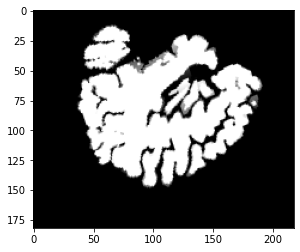

(182, 218, 182)


In [73]:
show_image(IMAGE_whole_after,i=50)

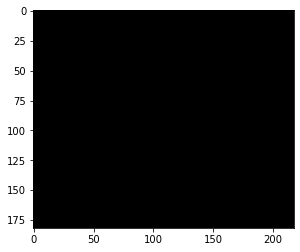

(182, 218, 182)


In [74]:
show_image(IMAGE_Hippo_mask,i=60)

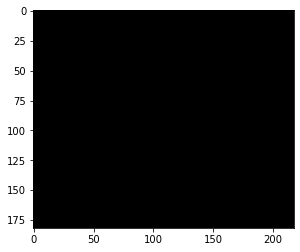

(182, 218, 182)


In [75]:
show_image(Image_Hippo,i=60)

In [59]:
import numpy as np
slices=[]

In [79]:

# IMAGE_Hippo_mask = sitk.GetArrayFromImage(IMAGE_Hippo_mask)
x_slices, y_slices, z_slices =  np.where(IMAGE_Hippo_mask!=0)
for j in range(z_slices.min(), z_slices.max()+1):
    slices.append(IMAGE_whole_after[:,:,j])


In [83]:
print(len(slices))

22


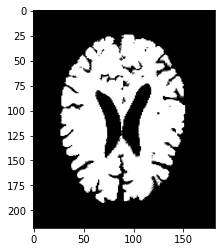

In [84]:
slice_1=sitk.GetArrayFromImage(slices[0])
slice_21=sitk.GetArrayFromImage(slices[21])
plt.imshow(slice_21,cmap='gray')
plt.show()

In [47]:
import numpy as np
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0]):
    ''' This function resamples images to 2-mm isotropic voxels.
      
        Parameters:
            itk_image -- Image in simpleitk format, not a numpy array
            out_spacing -- Space representation of each voxel
            
        Returns: 
            Resulting image in simpleitk format, not a numpy array
    '''
    
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)


In [22]:

atlas = sitk.ReadImage('E:\GP\Brain\MNI152_T1_2mm.nii\HarvardOxford-sub-maxprob-thr25-1mm.nii\HarvardOxford-sub-maxprob-thr25-1mm.nii')
Temp = sitk.ReadImage('MNI152_T1_1mm.nii')
# atlas = resample_img(atlas)
# img=resample_img(sitk_image)


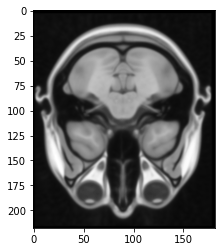

(182, 218, 182)


In [26]:
import numpy as np

show_image(Temp,i=30)

In [31]:
import nibabel as nib
atlas = nib.load('E:\GP\Brain\MNI152_T1_2mm.nii\HarvardOxford-sub-maxprob-thr25-1mm.nii\HarvardOxford-sub-maxprob-thr25-1mm.nii')
atlas = atlas.get_fdata()

hippocampus_mask = np.zeros_like(atlas)

hippocampus_mask = np.where(np.logical_or(atlas == 17, atlas == 53), 1, 0)
hippocampus_mask = hippocampus_mask.astype(np.uint8)
atlas = nib.load('E:\GP\Brain\MNI152_T1_2mm.nii\HarvardOxford-sub-maxprob-thr25-1mm.nii\HarvardOxford-sub-maxprob-thr25-1mm.nii')

hippocampus_img = nib.Nifti1Image(hippocampus_mask, atlas.affine)
nib.save(hippocampus_img, 'Hippocamps.nii')



In [32]:
# atlas = sitk.ReadImage('E:\GP\Brain\MNI152_T1_2mm.nii\MNI152_T1_2mm.nii')

# show_image(atlas,i=40)

57
77


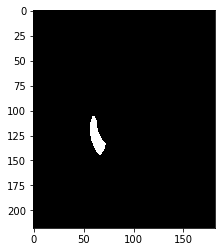

(182, 218, 182)


In [33]:
Hippo=sitk.ReadImage("Hippocamps.nii")
Hippo = sitk.GetArrayFromImage(Hippo)

x_slices, y_slices, z_slices =  np.where(Hippo!=0)
print(z_slices.min())
print(z_slices.max())

show_image(Hippo,i=74)

In [64]:
def registrate(sitk_fixed, sitk_moving, bspline=False):
    ''' Perform image registration using SimpleElastix.
        By default, uses affine transformation.
        
        Parameters:
            sitk_fixed -- Reference atlas (sitk .nii)
            sitk_moving -- Image to be registrated
                           (sitk .nii)
            bspline -- Whether or not to perform non-rigid
                       registration. Note: it usually deforms
                       the images and increases execution times
    '''
    
    elastixImageFilter = sitk.ElastixImageFilter()
    # print(sitk_moving)
    elastixImageFilter.SetFixedImage(sitk_fixed)
    elastixImageFilter.SetMovingImage(sitk_moving)

    parameterMapVector = sitk.VectorOfParameterMap()
    parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
    if bspline:
        parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    elastixImageFilter.Execute()
    return elastixImageFilter.GetResultImage()


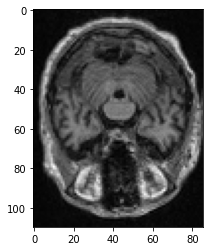

(78, 110, 86)


In [74]:
img=registrate(atlas,img)
path="E:/GP/image.nii"

show_image(img,i=50)

In [67]:
import os
def register_and_save(input_dir, output_dir, atlas):
    ''' Process the image name and copy the image to its
        corresponding destination folder.
        Parameters:
            filename -- Name of the image file (.nii)
            path -- The path were the image is located
            atlas -- Reference sitk image for registration
    '''
    # Get list of subdirectories in input directory

    subdirs = next(os.walk(input_dir))[1]
    for subdir in subdirs:
    # Get list of image file names in subdirectory
        image_file_names = os.listdir(os.path.join(input_dir, subdir))

    # Loop through each image file
        for image_file_name in image_file_names:    
            if "N3" in image_file_name:
                # prepare the origin path
                # load sitk image
                # prepare the destination path
                sitk_moving = sitk.ReadImage(os.path.join(input_dir, subdir, image_file_name))
                sitk_moving = resample_img(sitk_moving)
                registrated = registrate(atlas, sitk_moving)
                output_file_name = os.path.join(output_dir, image_file_name)
                print(output_file_name)
                sitk.WriteImage(registrated, output_file_name)


In [72]:
input_dir = 'E:/GP/Data_Classes/CN'
output_dir = 'E:/GP/Brain prep/Data/CN'
register_and_save(input_dir,output_dir,atlas)

E:/GP/Brain prep/Data/CN\ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001114556321_S13408_I118671.nii
E:/GP/Brain prep/Data/CN\ADNI_002_S_0413_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001114742166_S13893_I118673.nii


In [ ]:
# # images are divided into 20 subfolders after decompressing
# DATABASE = '/Volumes/ADNI/MRI/RAW/'
# DB_SUBFOLDERS = ['1/', '2/', '3/', '4/', '5/', '6/',
#                  '7/', '8/', '9/', '10/', '11/', '12/',
#                  '13/', '14/', '15/', '16/', '17/', 
#                  '18/', '19/', '20/']

# # prepare and organize the images
# for subdir in DB_SUBFOLDERS:
#     for path, dirs, files in os.walk(DATABASE + subdir):
#         if files:
#             for file in files:
#                 try:
#                     register_and_save(file, path, atlas)
#                 except RuntimeError:
#                     print('Exception with', os.path.join(path, file))


In [ ]:
# def skull_strip_nii(original_img, destination_img, frac=0.2):
#     ''' Practice skull stripping on the given image, and save
#         the result to a new .nii image.
#         Uses FSL-BET 
#         (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide#Main_bet2_options:)
        
#         Parameters:
#             original_img -- Original nii image
#             destination_img -- The new skull-stripped image
#             frac -- Fractional intensity threshold for BET
#     '''
    
#     btr = fsl.BET()
#     btr.inputs.in_file = original_img
#     btr.inputs.frac = frac
#     btr.inputs.out_file = destination_img
#     btr.cmdline
#     res = btr.run()


In [ ]:

# # database locations
# REG_DB = '/ADNI/MRI/REGISTERED/'
# SKULL_STRIPPED_DB = '/ADNI/MRI/SKULL_STRIPPED/'
# CLASS_FOLDERS = ['AD', 'MCI', 'CN']

# exceptions = []
# for folder in CLASS_FOLDERS:
#     origin_folder = os.path.join(REG_DB, folder)
#     dest_folder = os.path.join(SKULL_STRIPPED_DB, folder)
#     for path, _, files in os.walk(origin_folder):
#         for file in files:
#             try:
#                 img = os.path.join(path, file)
#                 dest = os.path.join(dest_folder, file)
#                 skull_strip_nii(img, dest, frac=0.2)
#             except RuntimeError:
#                 exceptions.append(img)

# # save the exceptions in case you want to do something about them
# # in our case, FSL BET failed with a couple of images, although it
# # was a very small amount so they were simply discarded
# with open(os.path.join(SKULL_STRIPPED_DB, 'exceptions.txt'), 'w') as f:
#     for item in exceptions:
#         f.write("%s\n" % item)


In [50]:
# !bet path_Original path -m

In [ ]:
# plt.figure(figsize=(12, 12))
# for i in range(12):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(image[i+90,:,:], cmap='gray')
#     plt.axis('off')
# plt.show()


